In [56]:
# -*- coding: utf-8 -*-
from __future__ import unicode_literals
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# plt.style.use('dark_background')
%matplotlib inline

# set different font to display korean characters
import matplotlib.font_manager as fm
fprop = fm.FontProperties(family='AppleGothic') # font from matplotlib inbuild

# to ignore plt warnings, not good practice but hey
import warnings
warnings.filterwarnings("ignore")

from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamulticore import LdaMulticore
import gensim.corpora as corpora
from pprint import pprint

# own utility modules
import mods.text as text
import mods.lyrics as lyrics
import replacements as replacements

## 0. Data Pre-Processing

In [57]:
# read data
raw = pd.read_csv('./data/lyrics.csv', encoding='utf8')
df = raw.copy()

# set column types
df['album_rd'] = df['album_rd'].astype('datetime64[ns]')

# add column to reflect year track is released in df
df['year'] = df['album_rd'].dt.year

# copy of df before filtering
unfiltered_df = df.copy()

# remove tracks with no lyrics
df = df[df['lyrics'].notna()]

# remove duplicate tracks (non-repackaged, not remix, not short versions)
df = df[~df['repackaged'] & ~df['remix'] & ~df['has_full_ver']]

# remove album extras (not tracks)
df = df[~df['track_title'].str.contains('notes', case=False) & ~df['track_title'].str.contains('skit', case=False)]

# fill null with "NA"
df = df.fillna('NA')

df.columns

Index(['id', 'album_title', 'eng_album_title', 'album_rd', 'album_seq',
       'track_title', 'kor_track_title', 'eng_track_title', 'lyrics',
       'hidden_track', 'remix', 'featured', 'performed_by', 'repackaged',
       'lang', 'has_full_ver', 'year'],
      dtype='object')

In [58]:
def pre_normalise(text):
    '''
    function to replace text before normalisation
    '''
    replacements = {'ille~gal': 'illegal gal', 'k-pop': 'kpop'}    
    replaced = [replacements[word] if word in replacements.keys() else word for word in text.lower().split()]
    return ' '.join(replaced)
    
df['lyrics'] = df['lyrics'].apply(lambda x: pre_normalise(x))

# expand lyrical contractions
df['lyrics'] = df['lyrics'].apply(lambda x: lyrics.expand_contractions(x))

# normalises lyrics (make text all lowercase, remove punctuation)
to_replace = replacements.replace_list.copy()
to_replace.update(lyrics.CONTRACTIONS)
df['lyrics'] = df['lyrics'].apply(lambda x: text.normalise(x, expand_contractions=True, replacements=to_replace))

# remove adlibs
df['lyrics'] = df['lyrics'].apply(lambda x: lyrics.remove_non_lex_vocables(x))

# do not include tracks that normalises to empty lyrics
df = df[df['lyrics'].str.len() > 0]

df.describe()

,id,album_seq,year
count,130.000000,130.000000,130.000000
mean,106.146154,7.115385,2016.392308
std,66.904550,4.711251,2.347673
min,0.000000,1.000000,2013.000000
25%,49.250000,3.000000,2014.000000
50%,103.500000,6.000000,2016.000000
75%,161.000000,10.000000,2018.000000
max,224.000000,19.000000,2020.000000


## 1. Prepare Model Inputs

In [59]:
# corpus
doc_clean = [l.split() for l in list(df['lyrics'])]

# Creating the term dictionary of courpus, every unique term is assigned an index.
dictionary = corpora.Dictionary(doc_clean)

# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above
doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]

In [60]:
lda =  LdaMulticore.load('model/lda_02May2021_112456')

In [61]:
temp_topic_columns = {'topic_{}'.format(i):None for i in range(0,7)}
temp_topic_columns

{'topic_0': None,
 'topic_1': None,
 'topic_2': None,
 'topic_3': None,
 'topic_4': None,
 'topic_5': None,
 'topic_6': None}

In [62]:
tdf = df.copy()
tdf = tdf.join(pd.DataFrame(temp_topic_columns, index=tdf.index))
tdf.describe()

,id,album_seq,year
count,130.000000,130.000000,130.000000
mean,106.146154,7.115385,2016.392308
std,66.904550,4.711251,2.347673
min,0.000000,1.000000,2013.000000
25%,49.250000,3.000000,2014.000000
50%,103.500000,6.000000,2016.000000
75%,161.000000,10.000000,2018.000000
max,224.000000,19.000000,2020.000000


In [63]:
def apply_lda(row):
    row_index = row.name
    text = row.lyrics
    doc = dictionary.doc2bow(text.split())
    # print(new_doc_bow)

    topic_scores = lda.get_document_topics(doc)
    for topic in topic_scores:
        # print(topic)
        col_name = 'topic_{}'.format(topic[0])
        # print(col_name)
        # print(type(topic[1]))
        tdf.at[row_index, col_name] = topic[1]
    # return lda.get_document_topics(doc)
    pass

In [64]:
tdf.apply(lambda x: apply_lda(x), axis=1)
tdf.filter(regex=("topic_*|^(track_title)"))
tdf.dtypes

id                          int64
album_title                object
eng_album_title            object
album_rd           datetime64[ns]
album_seq                   int64
track_title                object
kor_track_title            object
eng_track_title            object
lyrics                     object
hidden_track                 bool
remix                        bool
featured                   object
performed_by               object
repackaged                   bool
lang                       object
has_full_ver                 bool
year                        int64
topic_0                    object
topic_1                    object
topic_2                    object
topic_3                    object
topic_4                    object
topic_5                    object
topic_6                    object
dtype: object

In [65]:
for k in temp_topic_columns.keys():
    tdf[k] = tdf[k].astype(float)
tdf.dtypes

id                          int64
album_title                object
eng_album_title            object
album_rd           datetime64[ns]
album_seq                   int64
track_title                object
kor_track_title            object
eng_track_title            object
lyrics                     object
hidden_track                 bool
remix                        bool
featured                   object
performed_by               object
repackaged                   bool
lang                       object
has_full_ver                 bool
year                        int64
topic_0                   float64
topic_1                   float64
topic_2                   float64
topic_3                   float64
topic_4                   float64
topic_5                   float64
topic_6                   float64
dtype: object

In [66]:
# take highest topic score and store the topic in column 'topic'
tdf['topic']=tdf.filter(regex=("topic_[0-9]{1}")).idxmax(axis=1)

In [67]:
# set name to topics
temp_topic_columns = {'topic_0': 'optimism',
                    'topic_1': 'yolo',
                    'topic_2': 'party',
                    'topic_3': 'dreamy love',
                    'topic_4': 'realistic love',
                    'topic_5': 'missed love',
                    'topic_6': 'kid love'}

In [68]:
trimmed = tdf[['track_title', 'album_title', 'topic', 'year']]
# rename topics to labels
trimmed['topic'] = trimmed['topic'].apply(lambda t: temp_topic_columns[t])
trimmed.groupby(by=['topic']).agg({
    'track_title': 'count'
}).rename(columns={'track_title': 'Number of Tracks'})

,Number of Tracks
topic,
dreamy love,59
kid love,1
missed love,39
optimism,9
party,4
realistic love,11
yolo,7


In [122]:
trimmed.groupby(by=['album_title','topic']).count()

track_title  \
album_title                                        topic                         
2 Cool 4 Skool                                     dreamy love               5   
                                                   realistic love            1   
BE                                                 dreamy love               4   
                                                   missed love               1   
                                                   optimism                  1   
Dark and Wild                                      dreamy love               6   
                                                   kid love                  1   
                                                   missed love               2   
                                                   realistic love            1   
                                                   yolo                      3   
Dynamite (DayTime Version)                         party                     1   
LOVE YOURSELF 結 ‘Answer’                           dreamy love               3   
                                                   missed love               4   
                                                   realistic love            3   
LOVE YOURSELF 轉 ‘Tear’                             dreamy love               6   
                                                   missed love               2   
                                                   optimism                  1   
                                                   realistic love            1   
Love Yourself 承 ‘Her’                              dreamy love               3   
                                                   missed love               2   
                                                   realistic love            1   
                                                   yolo                      2   
MAP OF THE SOUL: 7                                 dreamy love               5   
                                                   missed love               5   
                                                   optimism                  3   
                                                   party                     1   
MAP OF THE SOUL: PERSONA                           dreamy love               1   
                                                   missed love               4   
                                                   optimism                  1   
                                                   party                     1   
O!RUL8,2?                                          dreamy love               4   
                                                   missed love               1   
                                                   optimism                  1   
                                                   realistic love            1   
                                                   yolo                      2   
Skool Luv Affair                                   dreamy love               7   
                                                   optimism                  1   
                                                   realistic love            1   
Skool Luv Affair (Special Addition)                dreamy love               1   
WINGS                                              dreamy love               4   
                                                   missed love              10   
You Never Walk Alone                               dreamy love               1   
                                                   missed love               1   
                                                   party                     1   
화양연화 The Most Beautiful Moment In Life Pt.1        dreamy love               4   
                                                   missed love               2   
                                                   realistic love            1   
화양연화 The Most Beautiful Moment In Life Pt.2      

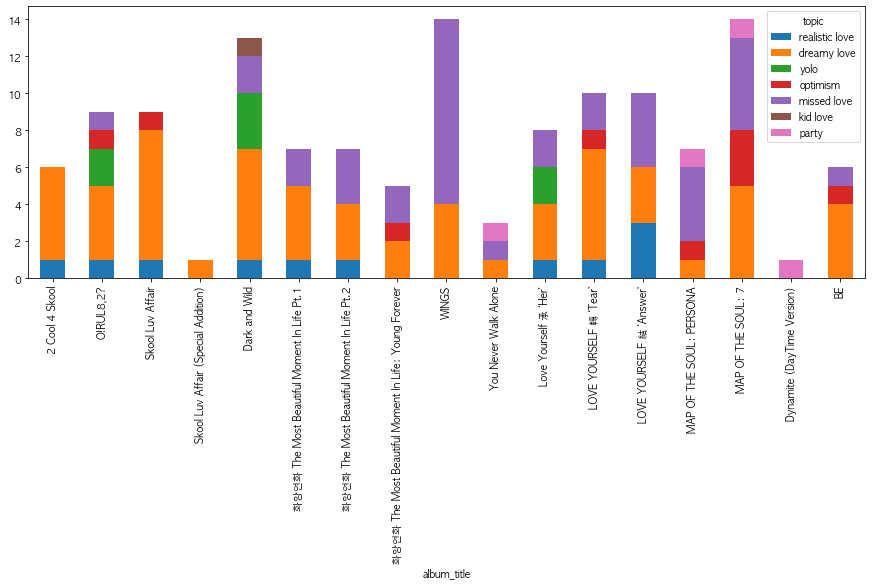

In [173]:
plt.rcParams["figure.figsize"] = (15,5)
plt.rcParams['font.family'] = 'AppleGothic'
temp = trimmed[['track_title', 'album_title', 'topic']]
temp = temp.pivot_table(index='album_title', columns='topic', aggfunc='count')
# temp
temp = trimmed.groupby(['album_title', 'topic'], sort=False)['track_title'].count().unstack('topic')

temp.plot(kind='bar', stacked=True)
# plt.legend(['dreamy love', 'kid love', 'missed love', 'optimism', 'party', 'realistic love', 'yolo'])
# plt.xlabel('album')

Text(0, 0.5, '%')

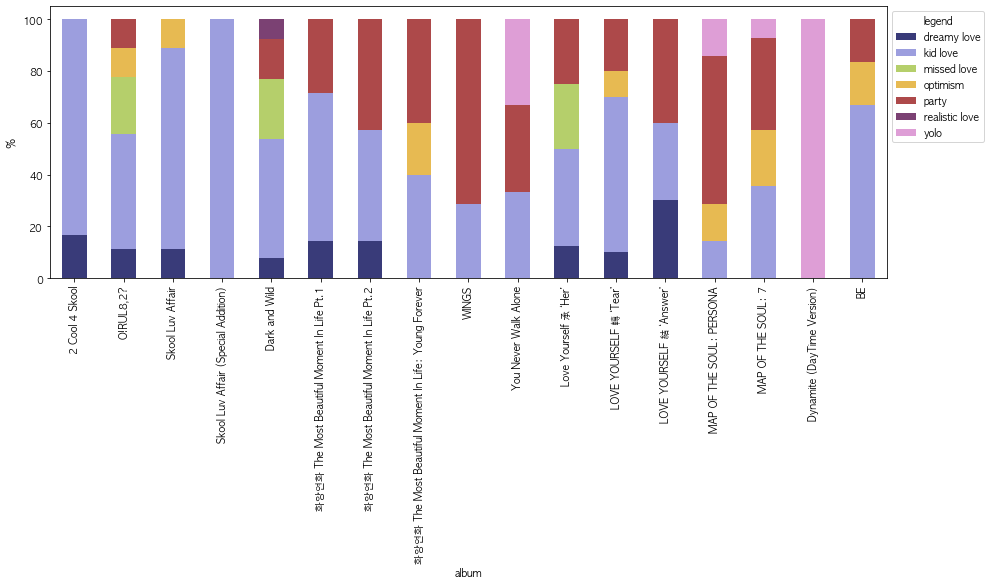

In [184]:
plot = temp.fillna(0).apply(lambda x: x*100/sum(x), axis=1).plot(kind='bar', stacked=True, cmap='tab20b')
# # per = temp.apply(lambda x: x*100/sum(x), axis=1)
plt.legend(['dreamy love', 'kid love', 'missed love', 'optimism', 'party', 'realistic love', 'yolo'], title='legend', bbox_to_anchor=(1, 1), loc='upper left')
plt.xlabel('album')
plt.ylabel('%')

# plt.savefig('topics_percentage.png', bbox_inches='tight')